In [1]:
# identificando os outliers para as variáveis
def limite_quantile_outliers(data, col):
    # primeiro quartil (q1)
    q1 = data[col].quantile(.25)
    # terceiro quartil (q3)
    q3 = data[col].quantile(.75)
    # cálculo do IQR (AMPLITUDE INTERQUARTIL)
    IQR = q3 - q1

    print(f'IQR da variável {col}: ', IQR)

    # definindo os limites

    # limite superior é +1.5 vezes o valor do IQR
    sup = q3 + 1.5 * IQR
    # limite inferior é -1.5 vezes o valor do IQR
    inf = q1 - 1.5 * IQR

    print(f'Limite superior de {col}: ', sup)
    print(f'Limite inferior de {col}: ', inf)


def boxplot_outliers(data, col, val):
    # Visulizando o boxplot da coluna price
    fig, ax = plt.subplots(figsize=(15, 3))
    data[col].plot(kind='box', vert=False)
    ax.set_title(f'Dataset - {col}')
    plt.show()
    print("O dataset possui {} colunas".format(data.shape[0]))
    print("{} Entradas acima de {}".format(len(data[data[col] > val]), val))
    print("Representam {:.2f}% do dataset".format(
        (len(data[data[col] > val]) / data.shape[0])*100))

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score, log_loss
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [173]:
arq_json = '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/02_Quanam/Data/metadata.json'
with open(arq_json, 'r', encoding='utf8') as f:
    data = json.load(f)
data = dict(data)

data = data.get('rows')

In [174]:
docs = [data[val]['doc']['payload'] for val in range(len(data))]

In [175]:
df = pd.DataFrame(docs)
df = df.astype(float)

In [178]:
df

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ID
0,477.17,66.78,422.36,15.05,21.89,84.24,404.0
1,425.90,66.15,467.58,29.73,21.84,75.85,456.0
2,479.29,68.39,529.71,24.76,20.65,80.39,457.0
3,564.59,67.19,517.24,28.99,19.55,85.92,486.0
4,506.51,62.05,499.52,23.30,20.77,75.50,487.0
...,...,...,...,...,...,...,...
12206,507.81,71.41,443.01,26.12,20.59,73.41,2913.0
12207,319.11,63.10,517.85,39.20,21.10,74.12,2985.0
12208,513.76,67.46,488.55,30.36,20.65,78.63,3003.0
12209,473.41,60.54,476.42,22.85,20.08,80.22,3007.0


# Data Viz

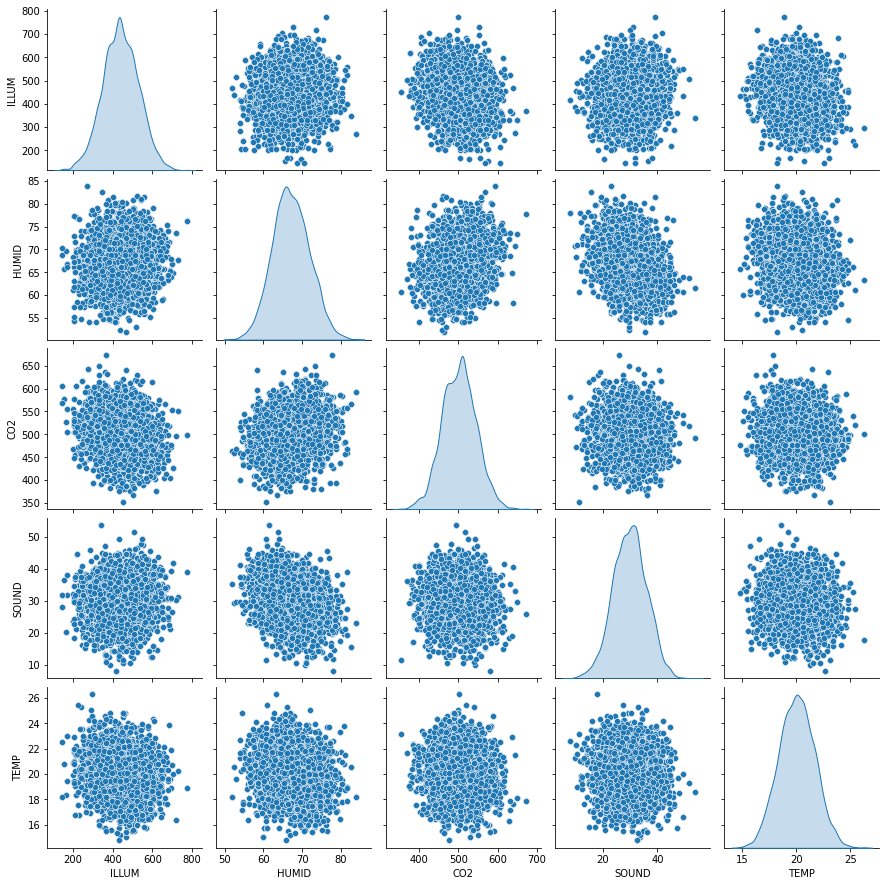

In [179]:
sns.pairplot(df.drop(['RYTHM', 'ID'], axis=1), diag_kind='kde');

# Outlier detection

In [180]:
df.describe()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ID
count,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000
mean,439.346853,67.097157,501.568495,29.850902,20.046507,80.150848,1623.486037
std,90.025370,4.767855,42.927900,6.152679,1.647841,6.744229,891.265101
min,145.480000,51.860000,352.820000,8.060000,14.760000,55.370000,1.000000
25%,377.610000,63.770000,471.390000,25.555000,18.920000,75.640000,864.000000
50%,437.340000,66.930000,502.480000,29.900000,20.050000,80.220000,1627.000000
75%,500.800000,70.330000,530.130000,33.960000,21.180000,84.660000,2390.500000
max,775.140000,83.900000,672.380000,53.780000,26.290000,108.900000,3200.000000


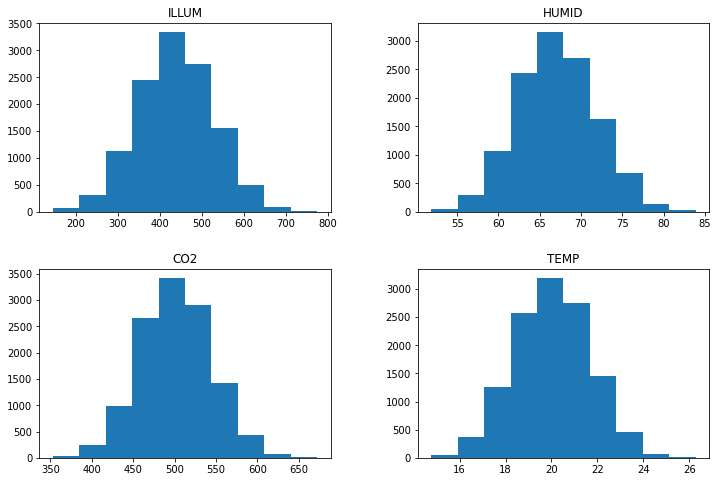

In [181]:
df[['ILLUM', 'HUMID', 'CO2', 'TEMP']].hist(figsize=(12,8), grid=False);

In [194]:
# cols = ['ILLUM', 'HUMID', 'CO2', 'TEMP', 'RYTHM']

# for col in cols:
#     print(col)
#     limite_quantile_outliers(df, col)
#     print('\n')

In [193]:
# valores_superior = [685.585, 80.1699, 618.24, 24.569, 98.19]
# for (col, val) in zip(cols, valores_superior):
#     boxplot_outliers(df, col, val)

In [189]:
df = df.drop(df[(df['ILLUM'] > 685.585) | (df['HUMID'] > 80.1699) | (df['CO2'] > 618.24) | (df['RYTHM'] < 62.11) | (df['RYTHM'] > 98.19)].index)
df.shape

(12000, 7)

## Split data

In [190]:
X = df.drop(['RYTHM', 'ID'], axis=1)
y = df['RYTHM']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 1.0 - Baseline

Target metrics: R2 Score

In [280]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_val)

array([[-0.4252046 ,  0.53284685,  1.31684395, -0.2852538 , -0.36913359],
       [-0.36362062, -0.36807647,  0.27006901, -0.13154657,  0.36840215],
       [-0.12402747,  1.11216397,  0.9190742 ,  1.59520694, -0.6373284 ],
       ...,
       [ 1.90172588,  0.67341644, -1.47912523, -0.04978741, -1.91734909],
       [-0.07649093, -0.29992152, -0.6280445 ,  0.57158222, -0.50323099],
       [ 0.27604365,  0.35819977,  0.91576536,  0.64025992,  0.47811821]])

In [281]:
lr = LinearRegression().fit(X_train, y_train)

In [199]:
def predict_rythm(model, X):
    return model.predict(X)

def print_metrics(y_true, y_pred):
    print('MSE:', mean_squared_error(y_true, y_pred))
    print('R2:', r2_score(y_true, y_pred))
    print("Root Mean Squared Error: ", mean_squared_error(y_true, y_pred) ** 0.5)

In [282]:
y_pred = predict_rythm(lr, X_val)
print_metrics(y_val, y_pred)

MSE: 34.231515575957566
R2: 0.19800982062623573
Root Mean Squared Error:  5.850770511305119


# 2.0 - Model

In [290]:
from sklearn.neighbors import KNeighborsRegressor

In [309]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsRegressor(n_neighbors=3, n_jobs=-1))])

In [310]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_jobs=-1, n_neighbors=3))])

In [304]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')

array([0.65657539, 0.6384988 , 0.63250686, 0.69063356, 0.67485573])

In [311]:
y_pred = predict_rythm(pipe, X_val)
print_metrics(y_val, y_pred)

MSE: 7.116522310185187
R2: 0.8332711564757191
Root Mean Squared Error:  2.667681073551557


In [307]:
subimission = pd.read_csv('https://raw.githubusercontent.com/maratonadev/desafio-2-2021/main/assets/answers.csv')
subimission.head(2)

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
0,0,337.90,63.29,518.13,22.38,18.59,0.0
1,1,342.96,63.19,488.85,37.36,20.41,0.0


In [316]:
x1 = subimission.drop(['ID', 'RYTHM'], axis=1)
sub_pred = pipe.predict(x1)
subimission['RYTHM'] = sub_pred
subimission.head(2)

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
0,0,337.90,63.29,518.13,22.38,18.59,77.663333
1,1,342.96,63.19,488.85,37.36,20.41,82.150000


In [317]:
subimission.to_csv('subimission.csv', index=False)

# 3.0 - Deep Leearning Model

In [262]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import RootMeanSquaredError

In [263]:
def FeedForward():
    model = Sequential()
    model.add(Dense(units=5, activation='relu', input_dim=(X_train.shape[1])))
    model.add(Dense(units=100, activation = 'relu'))
    model.add(Dense(units=100, activation = 'relu'))

    model.compile(optimizer = 'RMSprop', loss = 'mse', metrics = [RootMeanSquaredError()])

    return model

In [264]:
model = KerasRegressor(FeedForward, epochs=100, batch_size=10, verbose=1, validation_data=(X_val, y_val))

In [ ]:
# Train neural network
history = model.fit(X_train,  # Features
                    y_train,  # Target vector
                    )
